## Linear regression on the Boston House Prices dataset

In this exercise, you will perform linear regression on the Boston House Prices dataset.

This dataset contains median house prices in different areas around Boston. For each area, we have some information about it, that we will use as our features. We want to train a linear regression model that predicts the price of a house given the input features.

We don't have direct access to the dataset from PyTorch, but the `scikit` library provides a version of it.

An important part of the exercise will be to get used to process input dataset and translate it into a suitable format for your analysis.

In [1]:
# Import dataset
from sklearn.datasets import fetch_california_housing
import torch
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
dataset = fetch_california_housing()

In [2]:
print(dataset['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

Play around with the `dataset` variable to see what it contains. It is a *dictionary*, i.e. a Python structure with key-value pairs, where the keys can be arbitrary objects --- usually strings. 

To access the item with key `key` from a dictionary `dictionary`, use the syntax `dictionary[key]`.

The `keys()` method of a dictionary returns the set of keys. To start, try `print()`ing the contents of the the `DESCR` key.

The data in the dataset are Numpy arrays. To convert them to PyTorch tensors, just pass the array as the single argument of the `torch.tensor()` function.

From this point, prepare the data to process it as done in the previous exercise.

## Squeeze and unsqueeze

In [2]:
tensor_data = torch.from_numpy(dataset['data'])
if torch.cuda.is_available():
    tensor_data = tensor_data.to('cuda')


In [4]:
tensor_data.size()

torch.Size([20640, 8])

In [5]:
temp=torch.zeros(1, 2, 1, 2)
print('original tensor:\n' + str(temp))
print('original tensor size: ' + str(temp.size()))
temp3 = temp.squeeze()
print()
print('squeezed tensor:\n' + str(temp3))
print('squeezed tensor size: ' + str(temp3.size()))
temp4 = temp3.unsqueeze(1)
print()
print('unsqueezed tensor:\n' + str(temp4))
print('unsqueezed tensor size: ' + str(temp4.size()))

original tensor:
tensor([[[[0., 0.]],

         [[0., 0.]]]])
original tensor size: torch.Size([1, 2, 1, 2])

squeezed tensor:
tensor([[0., 0.],
        [0., 0.]])
squeezed tensor size: torch.Size([2, 2])

unsqueezed tensor:
tensor([[[0., 0.]],

        [[0., 0.]]])
unsqueezed tensor size: torch.Size([2, 1, 2])


### Correlations

One of the things you may want to do is remove unnecessary features. For example, if you have two highly-correlated features, you could use only one of them.

Feature correlation can be estimated using the Pearson correlation coefficient:

$$\text{corr}_{X_1,X_2} = \frac{\text{cov}(X_1,X_2)}{\sigma_{X_1} \sigma_{X_2}}$$

where $\text{cov}(X_1,X_2)$ is the covariance between features $X_1$ and $X_2$ (i.e., all values for that feature, from all observations), and $\sigma_X$ is the standard deviation of feature $X$.

All values $X_i$ are basically the columns of our data matrix. Given the vector `X_i` that contains all values for a feature, you can use the `X_i.std()` function to get the standard deviation of that vector.

You can also use the variant of `std()` that takes an input `dim` argument to compute *all* standard deviations for each column in the full data matrix.

To compute the covariance matrix, you are going to need to perform some computations. This is a good training exercise to learn how to manipulate tensors, while will be very useful later.

Let's suppose your data matrix is `X`, where each row is an observation and each column is a feature.

First of all, you will need to compute a vector `X_mean`, where each element is the mean value for each feature. To do this, you will need to use the `torch.mean()` or the `Tensor.mean()` function.

From there, you have to subtract the mean vector to each observation in the data matrix. Note that PyTorch supports an operation called *broadcasting*. In practice, if `X` has size $n \times d$, and if `X_mean` has size $d$ or $1 \times d$, then `X - X_mean` will automatically subtract `X_mean` from each row in `X`.

Finally, if $N$ is the number of observation and `X_cent` is the data matrix where the mean vector has been subtracted, you can compute the covariance matrix $\Sigma$ as:

$$\Sigma = \frac{X_{\text{cent}}^T X_{\text{cent}}}{N-1}$$

Each element $\Sigma_{ij}$ is going to be equal to $\text{cov}(X_i,X_j)$. From those values and from the $\sigma_i$ values, you can compute the correlation matrix.

correlation coefficient:
tensor([[ 1., -1.],
        [-1.,  1.]])


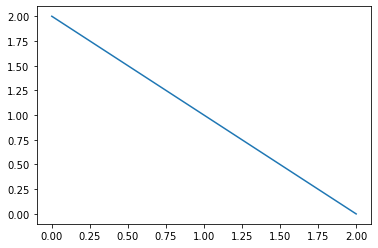

In [6]:
temp = torch.tensor([[0,1,2], [2,1,0]])

plt.plot(temp[0], temp[1])

corr_coeff = torch.corrcoef(temp)
print('correlation coefficient:\n' + str(corr_coeff))

In [65]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, no_norm_thresh=False, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    no_norm_thresh
        Toggle threshold normalization.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None and not no_norm_thresh:
        threshold = im.norm(threshold)
    elif threshold is None:
        threshold = im.norm(data.max())/2.
    else:
        threshold = im.norm(threshold)
        threshold2 = im.norm(-threshold)

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold or (no_norm_thresh and im.norm(data[i, j]) < threshold2))])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

def format_func(x, pos):
    return "{:.2f}".format(x).replace("0.", ".").replace("1.00", "")

Real correlation coefficient matrix:
tensor([[ 1.0000, -0.1190,  0.3269, -0.0620,  0.0048,  0.0188, -0.0798, -0.0152],
        [-0.1190,  1.0000, -0.1533, -0.0777, -0.2962,  0.0132,  0.0112, -0.1082],
        [ 0.3269, -0.1533,  1.0000,  0.8476, -0.0722, -0.0049,  0.1064, -0.0275],
        [-0.0620, -0.0777,  0.8476,  1.0000, -0.0662, -0.0062,  0.0697,  0.0133],
        [ 0.0048, -0.2962, -0.0722, -0.0662,  1.0000,  0.0699, -0.1088,  0.0998],
        [ 0.0188,  0.0132, -0.0049, -0.0062,  0.0699,  1.0000,  0.0024,  0.0025],
        [-0.0798,  0.0112,  0.1064,  0.0697, -0.1088,  0.0024,  1.0000, -0.9247],
        [-0.0152, -0.1082, -0.0275,  0.0133,  0.0998,  0.0025, -0.9247,  1.0000]],
       dtype=torch.float64)


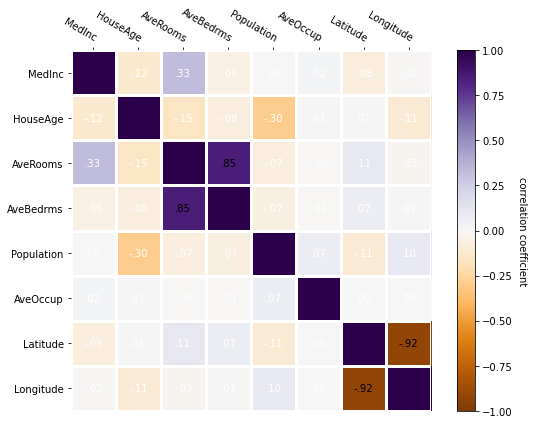

In [67]:
# Real correlation matrix
corr_coeff = torch.corrcoef(tensor_data.T)
print('Real correlation coefficient matrix:\n' + str(corr_coeff))
_, ax = plt.subplots(figsize=(8, 6))
im, _ = heatmap(corr_coeff, dataset['feature_names'], dataset['feature_names'], ax=ax, cmap='PuOr',
                cbarlabel='correlation coefficient', vmin=-1, vmax=1)
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(format_func), textcolors=('white', 'black'), threshold=0.5, no_norm_thresh=True)
plt.tight_layout()

AOnce you have a correlation matrix `corr`, you can visualize it using the following code.

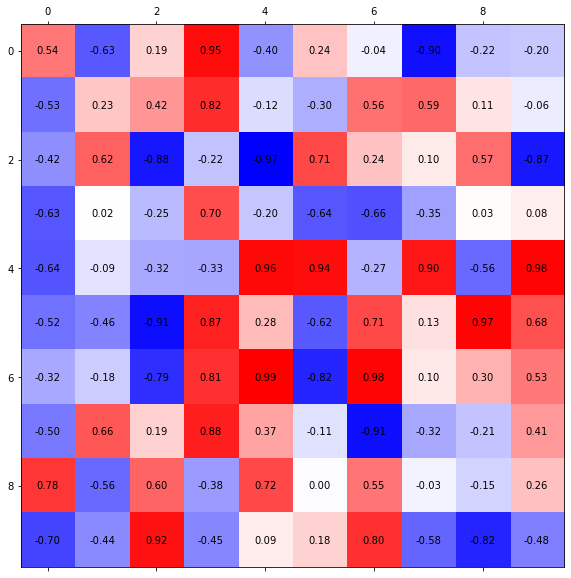

In [14]:
# Create random correlation matrix
corr = torch.rand(10, 10)*2 - 1
# Plot matrix
plt.figure(figsize=(10, 10))
ax = plt.gca() #get axix from figure
ax.matshow(corr, cmap=plt.cm.bwr) #matshow() Display an array as a matrix

for i in range(corr.size(0)):
    for j in range(corr.size(1)):
        c = f"{corr[i,j].item():.2f}"
        ax.text(j, i, str(c), va='center', ha='center')


An additional test you can carry out is to see which feature mostly correlate *with the targets*, to see which features are most important for regression.

**Note that you should do this on the training set only. You can't look at the test set during training.**

To do so, you can create an "extended" data matrix `data_ext` where the targets have been added as a new feature column. Then you can run the correlation analysis to see which features are mostly related.

Finally, run some tests by:

- Computing the accuracy of your model when you remove/keep features that correlate with each other.
- Computing the accuracy of your model when you remove/keep features that correlate with the targets.